# Температура плавления стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Изучение данных

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

!pip install shap
import shap

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

     |████████████████████████████████| 572 kB 2.6 MB/s eta 0:00:01


### Данные об электродах

In [2]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv')
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [3]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Видим значение реактивной мощности сильно ниже 0. Скорее всего, что это выброс. Посмотрим сколько значений меньше 0

In [5]:
data_arc.loc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Имеем всего одно аномальное значение, значит можем смело его удалить

In [6]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]

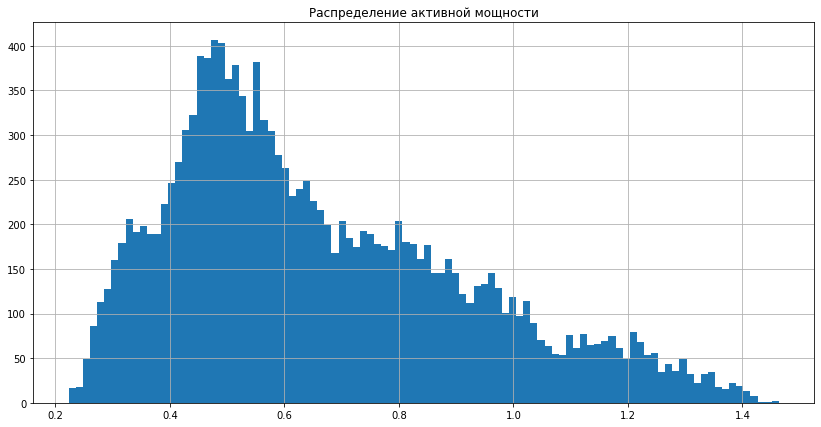

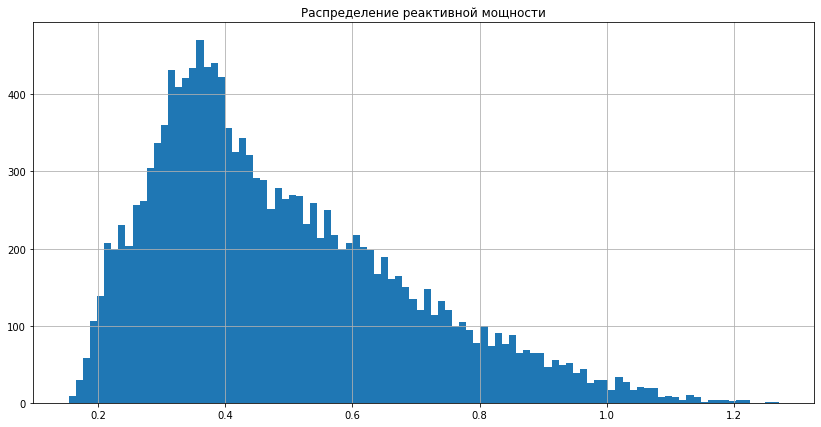

In [7]:
#построим графики по активной и реактивной мощности
data_arc['Активная мощность'].hist(bins=100, figsize=(14, 7))
plt.title('Распределение активной мощности')
plt.show()
data_arc['Реактивная мощность'].hist(bins=100, figsize=(14, 7))
plt.title('Распределение реактивной мощности')
plt.show()

В сети сказано следующее:

**Фактически, активная мощность определяет скорость полезного потребления энергии. Реактивная мощность — мощность определяемая электромагнитными полями, образующимися в процессе работы приборов. Реактивная мощность, как правило, является «вредной» или «паразитной». Реактивная мощность определяется характером нагрузки.**

Можно сказать, что мощности связаны между собой. Построим по ним график зависимости и взглянем на их корреляцию

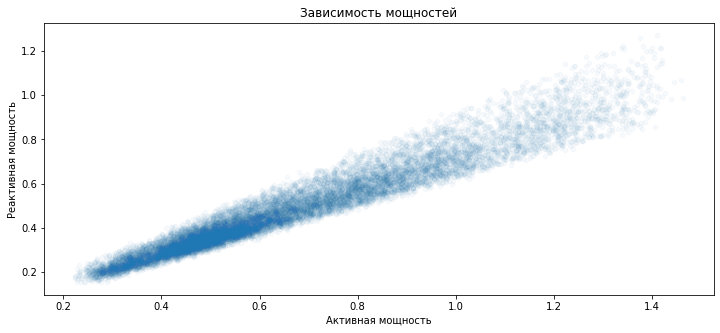

Коэффициент корреляции: 0.9663734456187294


In [8]:
data_arc.plot(x='Активная мощность', y='Реактивная мощность', figsize=(12, 5), 
              kind='scatter', title='Зависимость мощностей', alpha=0.03)
plt.show()
print('Коэффициент корреляции:',data_arc['Реактивная мощность'].corr(data_arc['Активная мощность']))

По графику видно следующее:

* сделав график более прозрачным, мы увидели область данных с самой высокой частотой
* чем ниже активная мощность, тем ближе к ней реактивная. С увеличением появляется небольшой разброс
* по коэффициенту корреляции можно сказать, что активная и реактивная мощность полностью связаны друг с другом

In [9]:
data_arc['key'].sort_values()

0           1
1           1
2           1
3           1
4           1
         ... 
14873    3241
14874    3241
14871    3241
14872    3241
14875    3241
Name: key, Length: 14875, dtype: int64

In [10]:
#посмотрим на количество уникальных партий
data_arc['key'].nunique()

3214

In [11]:
#проверим наличие явных дубликатов в таблице
data_arc.duplicated().sum()

0

In [12]:
#выведем количество пропущенных значений для каждого столбца
data_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

### Данные о подаче сыпучих материалов (объём)

In [13]:
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [14]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [15]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [16]:
#посмотрим на уникальные значения столбцов
for i in data_bulk.columns:
    print(i)
    print(data_bulk[i].sort_values().unique())

key
[   1    2    3 ... 3239 3240 3241]
Bulk 1
[ 10.  16.  19.  21.  22.  24.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  36.  37.  38.  39.  41.  43.  44.  46.  47.  48.  50.  51.  52.
  54.  58.  60.  62.  63.  65.  67.  69.  73.  74.  75.  78.  83.  90.
  92.  94. 104. 118. 185.  nan]
Bulk 2
[228. 232. 233. 236. 242. 246. 247. 248. 249. 254. 257. 258. 270. 282.
 325.  nan]
Bulk 3
[  6.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  34.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129.
 130. 131. 132. 133. 134. 135. 136. 137. 13

Перед нами различные сыпучие материалы, которые добавляют для легирования стали. Судя по данным в разные партии добавляют разные материалы. Больше всего было добавлено мтаериалов под номерами **3, 4, 12, 14, 15**. Материал под номером 8 добавили только один раз. Ещё можно заметить, что не во все партии добавляли материалы, ибо количество партий у нас 3241, а материалы добавили только в 3129.

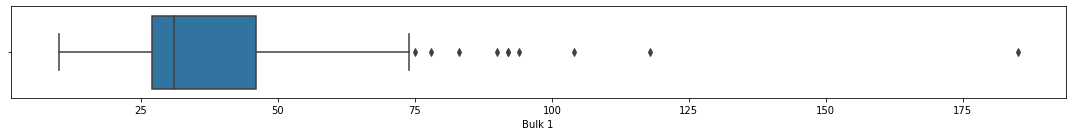

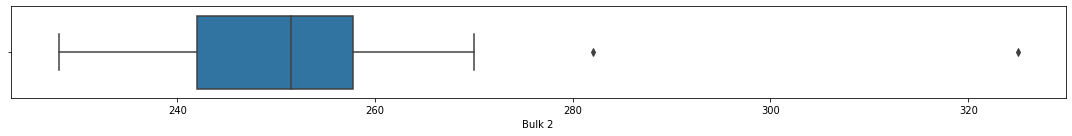

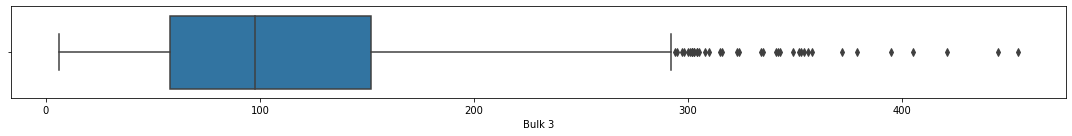

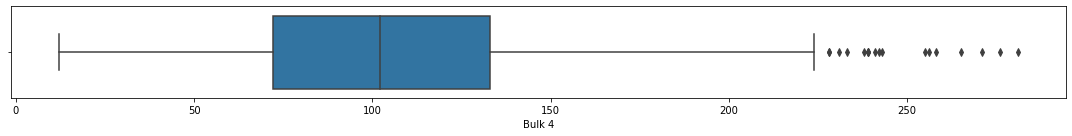

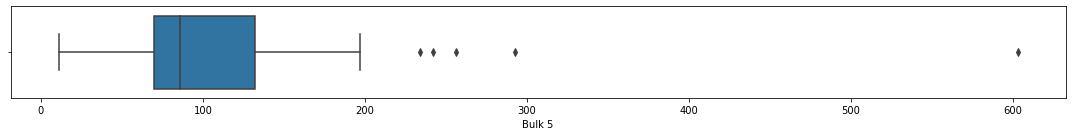

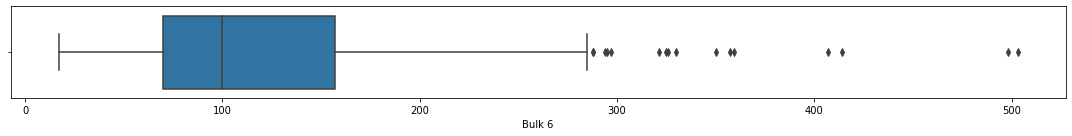

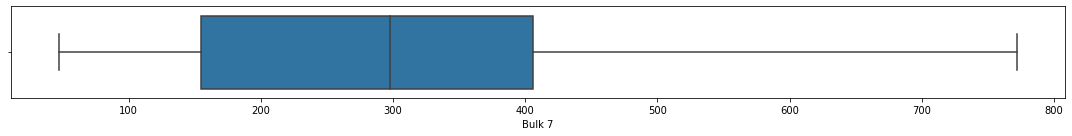

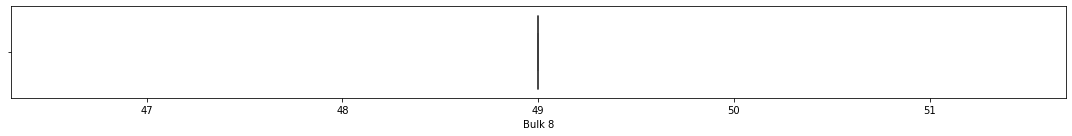

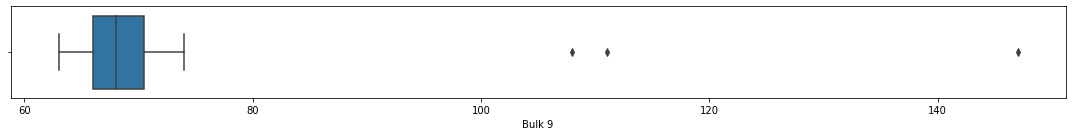

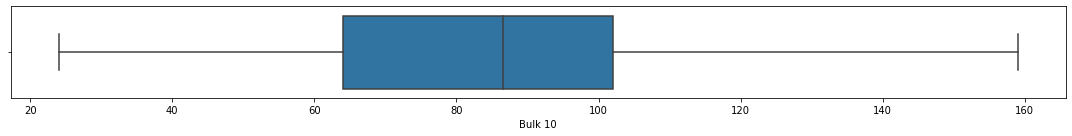

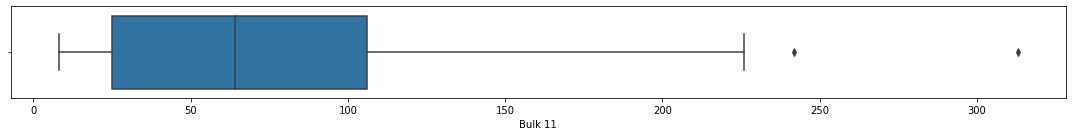

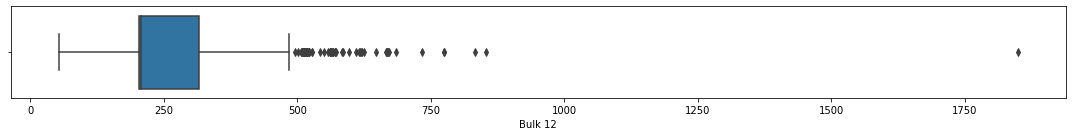

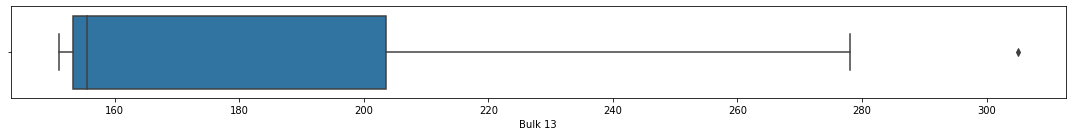

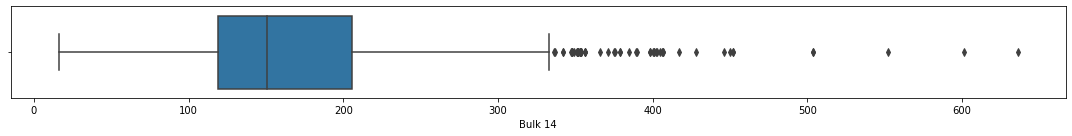

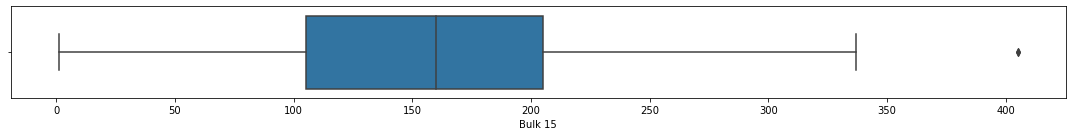

In [17]:
#посмотрим на распределение материалов   
for i in data_bulk.columns[1:]:   
    plt.figure(figsize=(15, 2))
    sns.boxplot(data_bulk[i])
    plt.tight_layout()
    plt.show()

Почти на всех графиках виден сильный выброс справа. Предполагаю, что их пока можно не трогать. Есть вероятность, что это некая особенность процесса.

### Данные о подаче сыпучих материалов (время)

In [18]:
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [19]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Значения полностью соответствуют таблице data_bulk. Есть предположение, что эта таблица не пригодится в дальнейшем. Вот совсем не вижу использования для неё.

### Данные о продувке сплава газом

In [20]:
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [21]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [22]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [23]:
#посмотрим на кол-во уникальных партий
data_gas['key'].nunique()

3239

Какие-то две партии не подвергались обработке газом

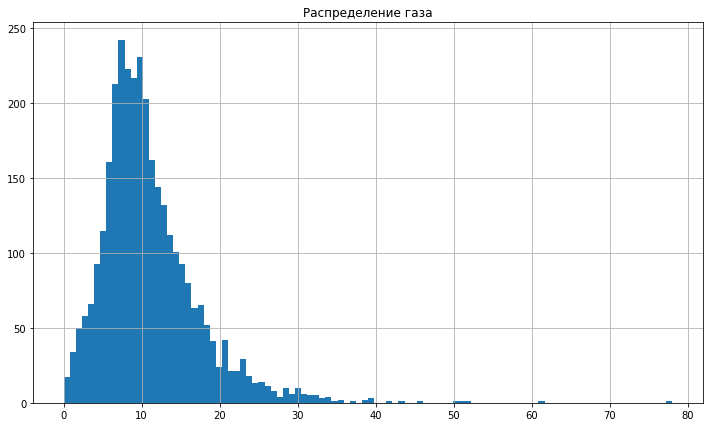

In [24]:
#построим график по газу
data_gas['Газ 1'].hist(bins=100, figsize=(12, 7))
plt.title('Распределение газа')
plt.show()

Видно небольшое количество выбросов, не хочу их сейчас удалять, ибо они могут быть связаны с процессом обработки.

### Результаты измерения температуры

In [25]:
data_temp = pd.read_csv('/datasets/data_temp_new.csv')
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [26]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [27]:
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [28]:
#посмотрим на кол-во уникальных партий
data_temp['key'].nunique()

3216

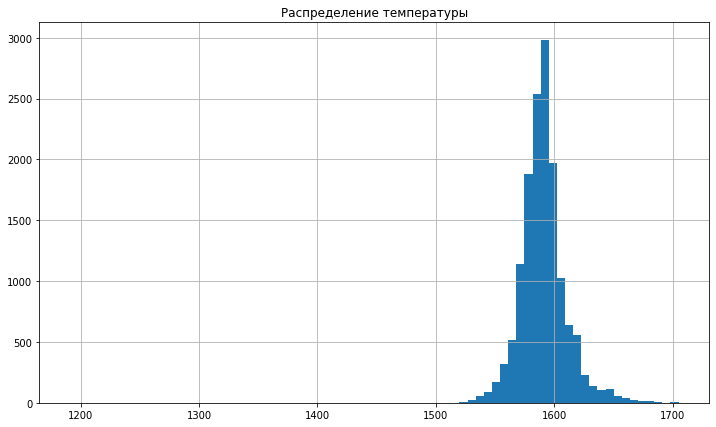

In [29]:
#построим график по температуре
data_temp['Температура'].hist(bins=75, figsize=(12, 7))
plt.title('Распределение температуры')
plt.show()

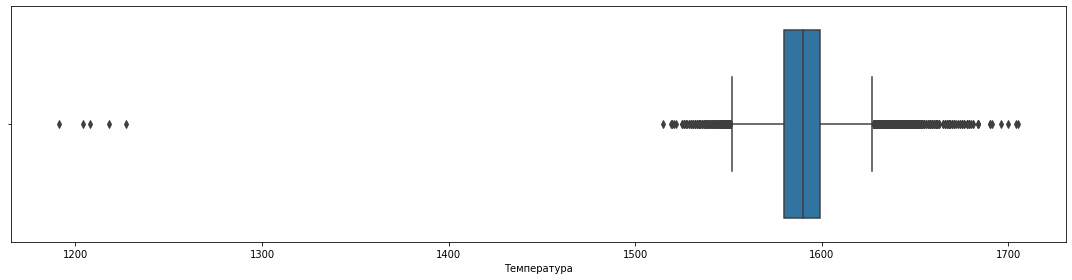

In [30]:
#поскольку не особо видно выбросы, то построим ещё один график
plt.figure(figsize=(15, 4))
sns.boxplot(data_temp['Температура'])
plt.tight_layout()
plt.show()

Исходя из задания можно сделать вывод, что это одна из самых главных таблиц. Температура точно будет главным признаком. На этапе предобработки нужно будет грамотно поработать с этой таблицей. Есть несколько мыслей, что можно будет сгруппировать данные по партиям и посмотреть на поведение температуры

### Данные о проволочных материалах (объём)

In [31]:
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [33]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [34]:
#посмотрим на кол-во уникальных партий
data_wire['key'].nunique()

3081

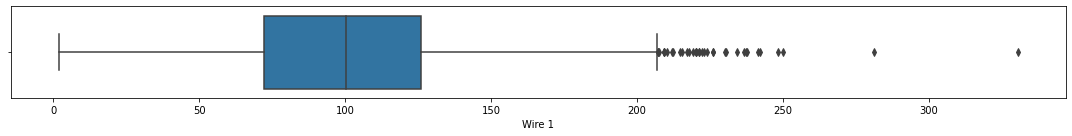

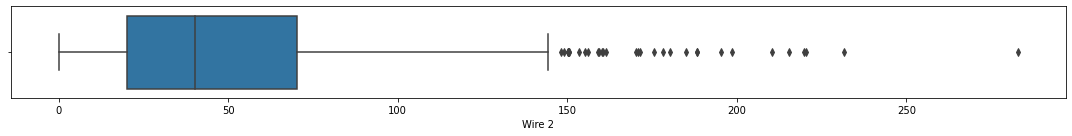

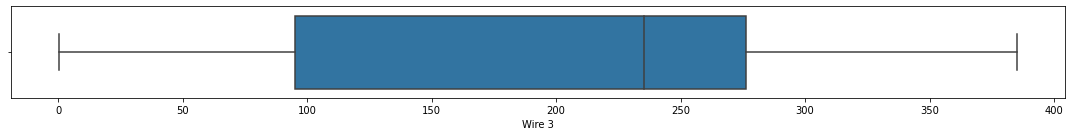

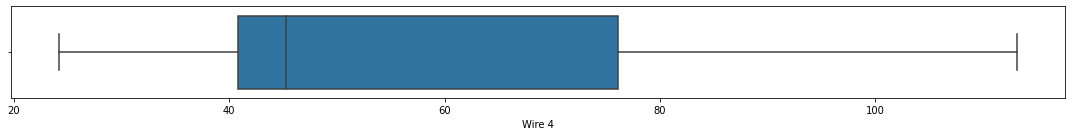

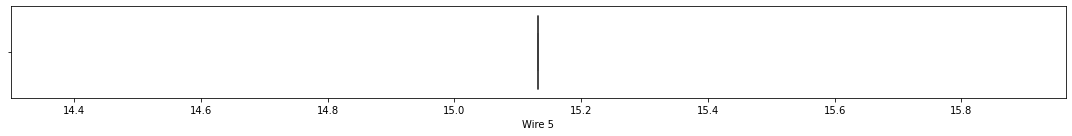

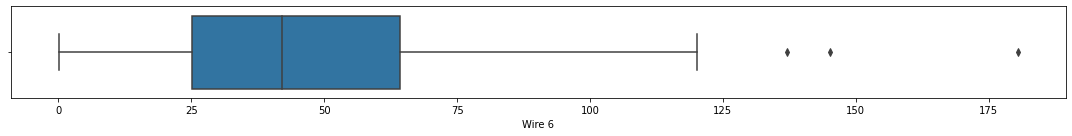

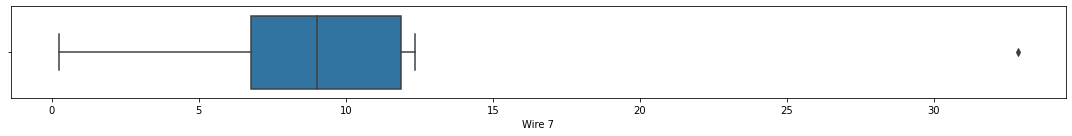

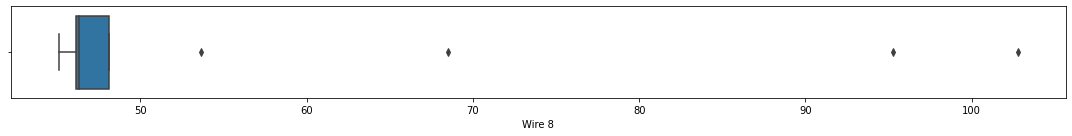

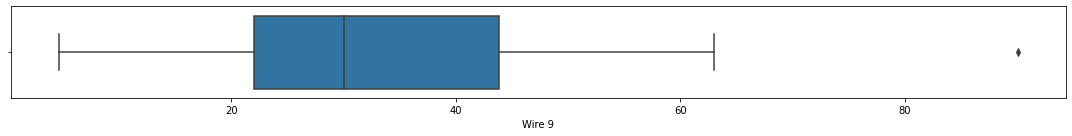

In [35]:
#посмотрим на распределение проволочных материалов 
for i in data_wire.columns[1:]:   
    plt.figure(figsize=(15, 2))
    sns.boxplot(data_wire[i])
    plt.tight_layout()
    plt.show()

Больше всего в сплав добавляли проволочные материалы под номером 1 и 2, остальные толком не использовались. Как и с сыпучими материалами почти на каждом графике есть сильный выброс справа. Вполне возможно, что это связано.

### Данные о проволочных материалах (время)

In [36]:
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Как и с data_bulk_time я очень сомневаюсь, что эта таблица пригодится нам в исследовании. Возможно я ошибаюсь, но я совсем не вижу использования для неё.

# Вывод по первому шагу

При первичном осмотре мы выяснили:
* В таблицах разное количество номеров партии
* Активная и реактивная мощность имеют прямю связь
* Дата приведена к неправильному типу
* В некоторых данных имеются аномальные значения
* Некоторые таблицы могут нам не пригодиться в дальнейшем (уточнить)
* Некоторые сыпучие и проволочные материалы толком и не используют.

# План работы

1. Изучить данные. Просмотреть общую информацию и построить графики, чтобы взглянуть на распределение данных.(Готово)
2. Провести предобработку данных. Обработать обнаруженные выбросы, привести дату к нужному формату.
3. Подготовить признаки. Температура будет точно главным признаком.  Создать единую таблицу.
4. Построить модели. Попробовать минимум 3 модели с подбором гипперпараметров.
5. Оценить эффективность моделей.
6. Итоговый вывод.

## Предобработка данных

### Работа с дубликатами, пропусками, выбросами и типом данных

In [38]:
#проверим наличие явных дубликатов для оставшихся таблиц, с которыми будем работать
display(data_bulk.duplicated().sum())
display(data_gas.duplicated().sum())
display(data_temp.duplicated().sum())
data_wire.duplicated().sum()

0

0

0

0

Поскольку таблицу data_arc мы проверили ещё на первом шаге, то можно спокойно сказать, что дубликаты отсутствуют

Теперь взглянем на пропуски:

* data_arc мы рассмотрели на первом этапе - пропусков нет
* В data_bulk и data_wire по первичному анализу было видно большое кол-во NaN. Мы знаем, что сыпучие и проволочные материалы используются далеко не все. В дальнейшем заменим на 0.

Проверим пропуски в таблице data_gas и data_temp

In [39]:
print('Пропуски в данных о продувке сплава газом')
display(data_gas.isna().sum())
print('Пропуски в результатах измерения температуры')
data_temp.isna().sum()

Пропуски в данных о продувке сплава газом


key      0
Газ 1    0
dtype: int64

Пропуски в результатах измерения температуры


key                0
Время замера       0
Температура     3427
dtype: int64

В таблице data_gas пропуски отсутствуют, а вот в data_temp присутствуют. Поскольку мы выяснили, что конечная температура будет нашим главным признаком, то надо получше рассмотреть эти пропуски.

Для начала удалим аномальные выбросы в data_temp. В data_arc мы удалили аномальные выбросы ещё на первом этапе.

In [40]:
#взглянем на кол-во выбросов с температурой меньше 1400 градусов
data_temp.query('Температура < 1400')

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [41]:
#удалим выбросы
data_temp = data_temp.query('Температура > 1400')
data_temp.query('Температура < 1400')

,key,Время замера,Температура


In [42]:
#за счёт условия ещё исчезли и все строки с отсутствующей температурой
data_temp.isna().sum()

key             0
Время замера    0
Температура     0
dtype: int64

С пропусками и выбросами в температуре разобрались. Продолжим работать с этой таблицей чуть дальше.

In [43]:
#изменим тип столбцов с object на datetime во всех нужных таблицах
data_arc['Начало нагрева дугой'] = pd.to_datetime(
    data_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

data_arc['Конец нагрева дугой'] = pd.to_datetime(
    data_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

data_temp['Время замера'] = pd.to_datetime(
    data_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')

### Подготовка главного признака

Нужно отобрать лишь те партии, где есть минимум две записи по температуре.

In [44]:
#сгруппируем данные по партиям и посмотрим в скольких из них только один замер температуры
data_temp_x = data_temp.groupby('key')['Температура'].count().reset_index()
data_temp_x['Температура'].value_counts()

1     740
5     689
6     579
4     394
7     389
8     151
3     136
9      66
2      33
10     21
11      7
12      3
14      2
16      2
13      2
17      1
Name: Температура, dtype: int64

In [45]:
#выбираем партии с одним замером
data_temp_y = data_temp_x.query('Температура == 1')['key']
data_temp_y

192      195
276      279
2477    2500
2478    2501
2479    2502
        ... 
3210    3237
3211    3238
3212    3239
3213    3240
3214    3241
Name: key, Length: 740, dtype: int64

In [46]:
#убираем партии с одним замером
data_temp = data_temp.query('key not in @data_temp_y')
data_temp.query('Температура == 1')['key']

Series([], Name: key, dtype: int64)

In [47]:
#теперь найдём время первого и последнего замера температуры
data_temp_time_minmax = pd.pivot_table(data_temp,
                                       index='key',
                                       values='Время замера',
                                       aggfunc={'Время замера': [min, max]}).reset_index()
data_temp_time_minmax

,key,max,min
0,1,2019-05-03 11:30:38,2019-05-03 11:02:04
1,2,2019-05-03 11:55:09,2019-05-03 11:34:04
2,3,2019-05-03 12:35:57,2019-05-03 12:06:44
3,4,2019-05-03 12:59:47,2019-05-03 12:39:27
4,5,2019-05-03 13:36:39,2019-05-03 13:11:03
...,...,...,...
2470,2495,2019-08-10 11:50:47,2019-08-10 11:27:47
2471,2496,2019-08-10 12:25:13,2019-08-10 11:56:48
2472,2497,2019-08-10 12:53:28,2019-08-10 12:37:26
2473,2498,2019-08-10 13:23:31,2019-08-10 12:58:11


In [48]:
#переведём первое и последнее время в списки
first_time = data_temp_time_minmax['min'].tolist()
last_time = data_temp_time_minmax['max'].tolist()

#в таблице data_temp с помощью срезов отберём нужное время 
data_temp_first = data_temp.query('`Время замера` in @first_time')

data_temp_last = data_temp.query('`Время замера` in @last_time')

#теперь соберём таблицу с первой и последней температурой
data_temp_main = (data_temp_first.merge(data_temp_last, on='key')
                                 .drop(['Время замера_x', 'Время замера_y'], axis=1)
                                 .rename(columns={'Температура_x' : 'first_temp', 'Температура_y' : 'last_temp'}))
data_temp_main

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


Можно смело сказать, что целевой признак подготовлен. Теперь можно приступить к подготовке остальных признаков. 


### Подготовка признаков для главной таблицы

Для начала рассчитаем сколько времени прошло с первого до последнего замера температуры

In [49]:
data_temp_time_minmax['total_time_heating'] = (data_temp_time_minmax['max'] - data_temp_time_minmax['min']).astype('int64')
data_temp_time_minmax['total_time_heating'] = pd.to_datetime(data_temp_time_minmax['total_time_heating']).dt.minute
data_temp_time_minmax = data_temp_time_minmax.drop(['max', 'min'], axis=1)
data_temp_time_minmax.head()

,key,total_time_heating
0,1,28
1,2,21
2,3,29
3,4,20
4,5,25


Теперь найдём сколько времени нагревали дугой каждую партию

In [50]:
data_arc_time = data_arc
data_arc_time['arc_heating_time'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc_time = pd.pivot_table(data_arc_time,
                               index='key',
                               values='arc_heating_time',
                               aggfunc=sum).reset_index()
#аналогично коду выше
data_arc_time['arc_heating_time'] = data_arc_time['arc_heating_time'].astype('int64')
data_arc_time['arc_heating_time'] = pd.to_datetime(data_arc_time['arc_heating_time']).dt.minute
data_arc_time.head()

,key,arc_heating_time
0,1,18
1,2,13
2,3,10
3,4,12
4,5,14


Заказчик сообщил информацию, что нам может пригодиться полная мощность. Попробуем её получить. Но снача разберёмся, что она из себя представляет. 

Полная мощность — величина, равная произведению действующих значений периодического электрического тока $I$ в цепи и напряжения 
$U$ на её зажимах $S = U * I$ связана с активной и реактивной мощностями соотношением:
$$ S = \sqrt {P^2 + Q^2} $$
где $P$ - активная мощность, $Q$ - реактивная мощность

In [51]:
#создадим столбец с расчётом полной мощности
data_arc['Полная мощность'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,arc_heating_time,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28,1.079934


In [52]:
#подготовим таблицу для дальнейшего объединения
data_arc_power = pd.pivot_table(data_arc,
                                index='key',
                                values=['Активная мощность', 'Реактивная мощность', 'Полная мощность'],
                                aggfunc=sum).reset_index()
data_arc_power

,key,Активная мощность,Полная мощность,Реактивная мощность
0,1,3.036730,3.718736,2.142821
1,2,2.139408,2.588349,1.453357
2,3,4.063641,5.019223,2.937457
3,4,2.706489,3.400038,2.056992
4,5,2.252950,2.816980,1.687991
...,...,...,...,...
3209,3237,2.541872,3.250657,2.025417
3210,3238,1.374821,1.723937,1.038103
3211,3239,4.848005,6.014480,3.541541
3212,3240,3.317679,4.082920,2.373552


Полную мощность для каждой партии мы получили.  Теперь можно подготовить сыпучие и проволочные материалы. Заказчик сообщил, что столбцы с небольшим кол-ом материала можно обеденить в один.

In [53]:
#вспомним таблицу
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [54]:
#убирём пропуски
data_bulk = data_bulk.fillna(0)

#столбцы, где меньше 1000 значений объединим в один
data_bulk['bulk_another'] = data_bulk[['Bulk 1', 'Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 6', 
                                       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 10', 'Bulk 11', 'Bulk 13']].sum(axis=1)
#оставляем нужные столбцы
data_bulk_main = data_bulk[['key', 'Bulk 3', 'Bulk 4', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'bulk_another']]
data_bulk_main.head()

,key,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,bulk_another
0,1,0.0,43.0,206.0,150.0,154.0,0.0
1,2,0.0,73.0,206.0,149.0,154.0,0.0
2,3,0.0,34.0,205.0,152.0,153.0,0.0
3,4,0.0,81.0,207.0,153.0,154.0,0.0
4,5,0.0,78.0,203.0,151.0,152.0,0.0


In [55]:
#вспомним таблицу
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [56]:
#убирём пропуски
data_wire = data_wire.fillna(0)

#Объединим все столбцы, кроме wire 1
data_wire['wire_another'] = data_wire[['Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 
                                       'Wire 8', 'Wire 9']].sum(axis=1)
#оставляем нужные столбцы
data_wire_main = data_wire[['key', 'Wire 1', 'wire_another']]
data_wire_main.head()

,key,Wire 1,wire_another
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


Мы подготовили признаки. Можно переходить к созданию главной таблицы. Если с результатами моделей будет что-то не то, то можно будет вернуться к этому этапу и попробовать подготовить ещё признаки.

### Создание главной таблицы

In [57]:
data_main = data_temp_main

#добавляем время между замерами температуры
data_main = data_main.merge(data_temp_time_minmax, on='key')

#добавляем мощность
data_main = data_main.merge(data_arc_power, on='key')

#добавляем суммарное время нагрева дугой
data_main = data_main.merge(data_arc_time, on='key')

#добавляем газ
data_main = data_main.merge(data_gas, on='key')

#добавляем сыпучие и проволочные материалы
data_main = data_main.merge(data_bulk_main, on='key')
data_main = data_main.merge(data_wire_main, on='key')

data_main.head()

,key,first_temp,last_temp,total_time_heating,Активная мощность,Полная мощность,Реактивная мощность,arc_heating_time,Газ 1,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,bulk_another,Wire 1,wire_another
0,1,1571.0,1613.0,28,3.036730,3.718736,2.142821,18,29.749986,0.0,43.0,206.0,150.0,154.0,0.0,60.059998,0.00000
1,2,1581.0,1602.0,21,2.139408,2.588349,1.453357,13,12.555561,0.0,73.0,206.0,149.0,154.0,0.0,96.052315,0.00000
2,3,1596.0,1599.0,29,4.063641,5.019223,2.937457,10,28.554793,0.0,34.0,205.0,152.0,153.0,0.0,91.160157,0.00000
3,4,1601.0,1625.0,20,2.706489,3.400038,2.056992,12,18.841219,0.0,81.0,207.0,153.0,154.0,0.0,89.063515,0.00000
4,5,1576.0,1602.0,25,2.252950,2.816980,1.687991,14,5.413692,0.0,78.0,203.0,151.0,152.0,0.0,89.238236,9.11456


In [58]:
#приведём названия столбцов к хорошему стилю
data_main = data_main.rename(columns= {'Активная мощность' : 'active_power',
                                       'Полная мощность' : 'full_power',
                                       'Реактивная мощность' : 'reactive_power',
                                       'Газ 1' : 'gas',
                                       'Bulk 3' : 'bulk_3',
                                       'Bulk 4' : 'bulk_4',
                                       'Bulk 12' : 'bulk_12',
                                       'Bulk 14' : 'bulk_14',
                                       'Bulk 15' : 'bulk_15',
                                       'Wire 1' : 'wire'})
data_main.head(1)

,key,first_temp,last_temp,total_time_heating,active_power,full_power,reactive_power,arc_heating_time,gas,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,bulk_another,wire,wire_another
0,1,1571.0,1613.0,28,3.03673,3.718736,2.142821,18,29.749986,0.0,43.0,206.0,150.0,154.0,0.0,60.059998,0.0


In [59]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2329 non-null   int64  
 1   first_temp          2329 non-null   float64
 2   last_temp           2329 non-null   float64
 3   total_time_heating  2329 non-null   int64  
 4   active_power        2329 non-null   float64
 5   full_power          2329 non-null   float64
 6   reactive_power      2329 non-null   float64
 7   arc_heating_time    2329 non-null   int64  
 8   gas                 2329 non-null   float64
 9   bulk_3              2329 non-null   float64
 10  bulk_4              2329 non-null   float64
 11  bulk_12             2329 non-null   float64
 12  bulk_14             2329 non-null   float64
 13  bulk_15             2329 non-null   float64
 14  bulk_another        2329 non-null   float64
 15  wire                2329 non-null   float64
 16  wire_a

In [60]:
#переведём температуру в int
data_main['first_temp'] = data_main['first_temp'].astype('int')
data_main['last_temp'] = data_main['last_temp'].astype('int')

Проверим признаки на мультиколлинеарность

,key,first_temp,last_temp,total_time_heating,active_power,full_power,reactive_power,arc_heating_time,gas,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,bulk_another,wire,wire_another
key,1.000000,-0.015911,-0.097242,-0.057591,-0.023422,-0.022668,-0.021349,-0.035915,-0.043486,-0.007271,-0.026147,0.025958,-0.110275,-0.045531,0.048811,-0.013564,0.015770
first_temp,-0.015911,1.000000,0.301320,0.106072,-0.154657,-0.154205,-0.152598,-0.390813,0.036047,-0.113925,0.164936,-0.080115,-0.181076,-0.063041,0.000865,0.262598,-0.062219
last_temp,-0.097242,0.301320,1.000000,0.057178,0.177339,0.175668,0.171878,0.279832,0.059160,-0.035977,0.187970,0.267424,0.114617,0.266414,-0.178539,0.317575,-0.202401
total_time_heating,-0.057591,0.106072,0.057178,1.000000,0.207443,0.206715,0.204380,0.154746,0.154238,0.050554,0.058841,0.091296,0.103885,0.013384,0.001110,0.198141,0.027602
active_power,-0.023422,-0.154657,0.177339,0.207443,1.000000,0.999030,0.992424,0.699960,0.370985,0.103241,0.005563,0.286073,0.300046,0.169845,0.212230,0.137923,0.095562
full_power,-0.022668,-0.154205,0.175668,0.206715,0.999030,1.000000,0.996868,0.698684,0.370555,0.102638,0.005236,0.286423,0.299090,0.169506,0.210940,0.138347,0.095489
reactive_power,-0.021349,-0.152598,0.171878,0.204380,0.992424,0.996868,1.000000,0.692912,0.367954,0.100949,0.004647,0.285721,0.295930,0.168109,0.207726,0.138365,0.094874
arc_heating_time,-0.035915,-0.390813,0.279832,0.154746,0.699960,0.698684,0.692912,1.000000,0.388528,0.099178,-0.025482,0.461371,0.465321,0.296405,0.163371,0.047240,0.072691
gas,-0.043486,0.036047,0.059160,0.154238,0.370985,0.370555,0.367954,0.388528,1.000000,0.059628,0.017578,0.217332,0.268889,0.043624,0.263353,0.117313,0.175348
bulk_3,-0.007271,-0.113925,-0.035977,0.050554,0.103241,0.102638,0.100949,0.099178,0.059628,1.000000,-0.295431,0.018371,0.010772,-0.012860,-0.025460,0.039637,0.066848


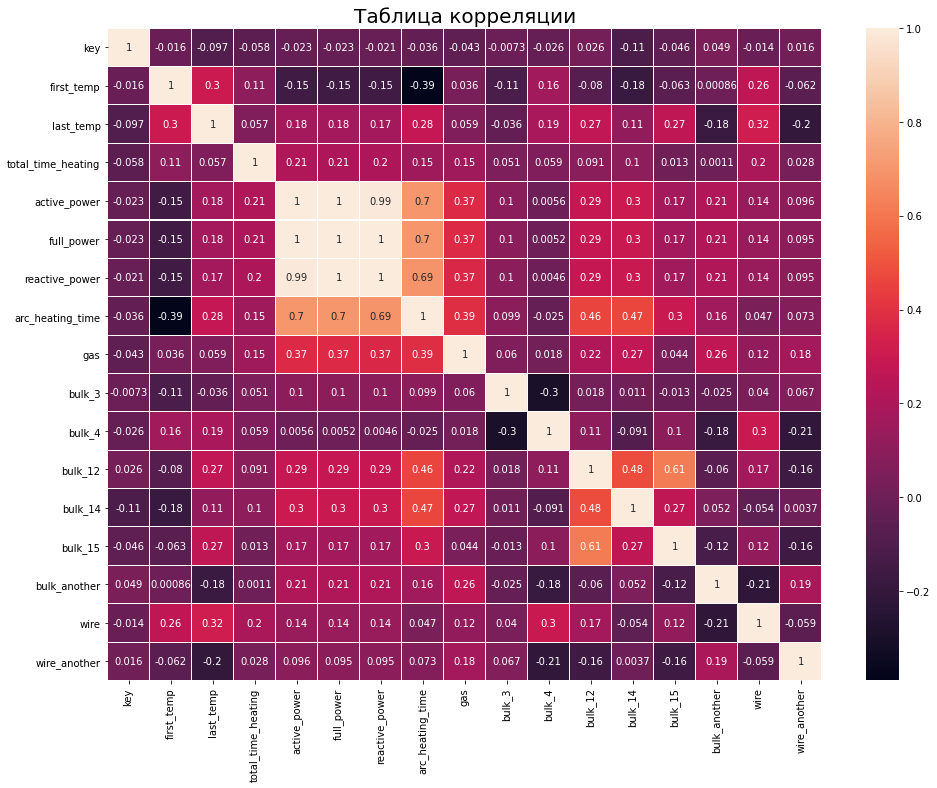

In [61]:
plt.figure(figsize=(16, 12))

data_main_corr = data_main.corr()
display(data_main_corr)

sns.heatmap(data_main_corr, annot=True, linewidths=0.1,)
plt.title('Таблица корреляции', size=20);

Из таблицы видно, что на последнюю температуру сильнее всего влияет:
* начальная температура
* время нагрева дугой
* мощность
* сыпучие материалы под номерами 4, 12, 14, 15
* проволочные материалы (wire)

На последнюю температуру не влияют:

* газ
* сыпучий материал под номером 3 и остальные(bulk_another)
* остальные проволочные материалы (wire_another)
* время между замерами температуры

Из таблицы видно, что активная, реактивная и полная мощность почти полностью дублируют себя. Оставим полную мощность, а остальные удалим. Ещё удалим признак key, ибо он не является бизнес-фактором.

In [62]:
data_main = data_main.drop(['key' ,'active_power', 'reactive_power'], axis=1)

# Вывод по второму шагу

В ходе второго этапа мы:

* обработали аномальные выбросы и пропуски
* привели названия столбцов в нужный стиль
* подготовили главный признак - последняя температура
* рассчитали время между замерами температуры
* рассчитали полную мощность по формуле
* создали основную для обучения таблицу
* выяснили какие признаки влияют на температуру, а какие не особо влияют
* удалили из основной таблицы признаки активной и реактивной мощности, ибо по таблице корреляции видно, что они практически идентичны

## Обучение моделей

### Подготовим выборки

In [65]:
#зададим random_state
r_state = 80523

features = data_main.drop(['last_temp'], axis=1)
target = data_main['last_temp']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.75, random_state=r_state)

print('Размер обучающей выборки:', features_train.shape[0],'\n'
      'Размер тестовой выборки:', features_test.shape[0])

Размер обучающей выборки: 1746 
Размер тестовой выборки: 583


Приступим к обучению моделей. Использовать будем следующие модели: линейная регрессия, случайный лес, LightGBM, CatBoost

### Линейная регрессия

In [67]:
%%time
lin = LinearRegression()
lin_scores = cross_val_score(lin, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
lin_score = sum(lin_scores) / len(lin_scores) * -1
print('Результаты кросс-валидации на модели линейной регрессии', lin_scores)
print('Усреднённый MAE:', lin_score)
print('')

Результаты кросс-валидации на модели линейной регрессии [-6.53933761 -6.30755084 -6.45947793 -6.02402894 -6.0715859 ]
Усреднённый MAE: 6.280396244979819

CPU times: user 59.9 ms, sys: 24 ms, total: 83.9 ms
Wall time: 32 ms


### Случайный лес

In [68]:
%%time
best_forest_mae = 0
best_depth = None
best_forest = None
best_est = None
for depth in range(1, 15, 2): 
    for est in range(50, 120, 10):
        forest = RandomForestRegressor(random_state=r_state, max_depth=depth, n_estimators=est)
        for_scores = cross_val_score(forest, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
        for_score = sum(for_scores) / len(for_scores) * -1
        if for_score > best_forest_mae:
            best_forest_mae = for_score
            best_depth = depth
            best_est = est
            best_forest = forest

print('Результаты кросс-валидации на модели случайного леса:', for_scores, 
      '\nЛучшая глубина:', best_depth, ', ' 
      '\nЛучшее дерево:', best_est, ', '
      '\nУсреднённый MAE:', best_forest_mae)

Результаты кросс-валидации на модели случайного леса: [-6.43023865 -6.25485791 -6.54305712 -5.93562898 -6.33181413] 
Лучшая глубина: 1 , 
Лучшее дерево: 70 , 
Усреднённый MAE: 7.59985342099805
CPU times: user 1min 38s, sys: 364 ms, total: 1min 38s
Wall time: 1min 38s


Очень странно рассчитывается MAE таким способом. Ради интереса хочу проверить результат через GridSearch

In [69]:
%%time
model = RandomForestRegressor()
hyperparams = [{'max_depth' : [5, 10, 15],
                'n_estimators' : [30, 60, 120], 
                'random_state' : [r_state],
                'min_samples_leaf' : [1, 2, 4]}]

grid_forest = GridSearchCV(model, hyperparams, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=0)
grid_forest.fit(features_train, target_train)
forest_best_params = grid_forest.best_params_

print(grid_forest.best_estimator_)
print(forest_best_params)
print('')
print('Усреднённый MAE:', (grid_forest.best_score_)*-1)
print('')

RandomForestRegressor(max_depth=15, n_estimators=120, random_state=80523)
{'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 120, 'random_state': 80523}

Усреднённый MAE: 6.290128158922118

CPU times: user 57.3 s, sys: 148 ms, total: 57.5 s
Wall time: 57.7 s


### LightGBM

In [70]:
%%time
model_lgbm = LGBMRegressor()
hyperparams = [{'num_leaves' : [10, 31, 50], 
                'learning_rate' : [0.05, 0.1, 0.2],
                'class_weight' : ['balanced', None],
                'random_state' : [r_state]}]

grid_lgbm = GridSearchCV(model_lgbm, hyperparams, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=0)
grid_lgbm.fit(features_train, target_train)
lgbm_best_params = grid_lgbm.best_params_

print(grid_lgbm.best_estimator_)
print(lgbm_best_params)
print('')
print('Усреднённый MAE:', (grid_lgbm.best_score_)*-1)
print('')

LGBMRegressor(learning_rate=0.05, random_state=80523)
{'class_weight': None, 'learning_rate': 0.05, 'num_leaves': 31, 'random_state': 80523}

Усреднённый MAE: 6.120851424009937

CPU times: user 32.6 s, sys: 650 ms, total: 33.2 s
Wall time: 33.5 s


### CatBoost

In [71]:
%%time
model_cat = CatBoostRegressor(random_state=r_state, learning_rate=0.01, depth=6, verbose=0)
cat_cv = cross_val_score(model_cat, 
                         features_train, 
                         target_train,
                         cv=5,
                         scoring='neg_mean_absolute_error')
val_score = cat_cv.mean() * -1

model_cat

print('Усреднённый MAE:', val_score)

Усреднённый MAE: 6.110364290839013
CPU times: user 13.4 s, sys: 527 ms, total: 13.9 s
Wall time: 21.6 s


### Анализ моделей

Создадим таблицу для удобного сравнения моделей

In [72]:
learning_time = [0.32, 57.3, 33.5, 21.6]
mae_data = [lin_score, (grid_forest.best_score_)*-1, (grid_lgbm.best_score_)*-1, val_score]

In [73]:
data_final = pd.DataFrame(data=[learning_time, mae_data], 
                          columns=['Linear', 'RandomForest', 'LightGBM', 'CatBoost'], 
                          index=['Learning Time', 'MAE']).round(2)
data_final

,Linear,RandomForest,LightGBM,CatBoost
Learning Time,0.32,57.30,33.50,21.60
MAE,6.28,6.29,6.12,6.11


# Вывод по третьему шагу

Обучив модели мы выяснили:

* CatBoost и LightGBM показали лучший результат MAE (6.11 и 6.12)
* Линейная регрессия обучается быстрее всех
* Дольше всех обучается случайный лес
* Случайный лес показал результат близкий к линейной регрессии, но время обучения гораздо выше
* Все модели успешно прошли минимальный порог MAE в 6.8
* LightGBM приоритетная модель

## Тестирование лучшей модели

Проведём тестирование на модели LightGBM

In [75]:
%%time
best_model_lgbm = grid_lgbm.best_estimator_
predictions = best_model_lgbm.predict(features_test)
test_mae = mean_absolute_error(predictions, target_test)
print('MAE на обучающей выборке =', test_mae)

MAE на обучающей выборке = 6.279675007727212
CPU times: user 17.6 ms, sys: 3.85 ms, total: 21.5 ms
Wall time: 8.69 ms


Хоть значение MAE и немного больше, чем при кросс-валидации, но порог в 6.8 модель спокойно перешла.

Сравним результат нашей модели с моделью DummyRegressor. Так мы проверим нашу модель на адекватность. Этот регрессор полезен в качестве простого базиса для сравнения с другими (реальными)регрессорами.

In [76]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)
predict_train = dummy.predict(features_train)
train_mae = mean_absolute_error(predict_train, target_train)
print('MAE обучающей выборки на dummy модели:', train_mae)

predict_test = dummy.predict(features_test)
test_mae = mean_absolute_error(predict_test, target_test)
print('MAE тестовой выборки на dummy модели:', test_mae)

MAE обучающей выборки на dummy модели: 7.964702825899549
MAE тестовой выборки на dummy модели: 8.385775671517742


Прекрасно видно, что результат нашей модели лучше. Проверка на адекватность пройдена.

### Анализ важности факторов

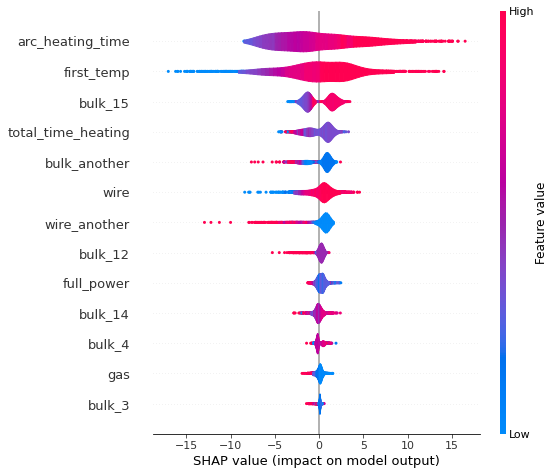

In [77]:
shap_test = shap.TreeExplainer(best_model_lgbm).shap_values(features_train)
shap.summary_plot(shap_test, features_train,
                      max_display=15, auto_size_plot=True, plot_type='violin')

Из графика можно сделать следующие выводы:

* Чем больше время работы дуги, тем сильнее это влияет на температуру 
* Большинство значений начальной температуры повышают значение целевого признака
* Чем меньше начальная температура и время нагрева, тем меньше это влияет на целевой признак
* Разные сыпучие материалы дают разное влияние на целевой признак. Самый стабильный материал bulk_15(чем их больше, тем выше вероятность повышения температуры). А bulk_12 почти всегда влияет на повышение целевого признака.
* Чем выше объём газа, тем меньше целевой признак
* Чем меньше времени прошло с первого до последнего замера температуры, тем выше вероятность повышения целевого признака
* Полная мощность почти всегда влияет на вероятность повышения температуры
* Повышение проволочных материалов могжет повысить и понизить целевой признак 

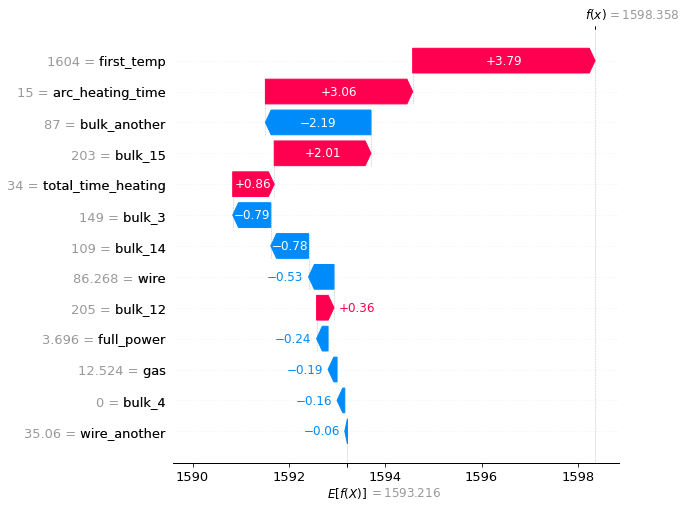

In [79]:
explainer = shap.TreeExplainer(best_model_lgbm)
shap_values = explainer(features_train)
shap.plots.waterfall(shap_values[0], max_display=15)

Если рассматривать важность признаков на одном объекте, то видно, что часть выводов с графика выше оказались верны. Только в этом примере получилось так, что полная мощность слегка понижает целевой признак

# Вывод по четвёртому шагу

Мы проверили модель LightGBM на тестовой выборке и получили значение MAE = 6.27, что ниже пороговой MAE = 6.8. Построили Dummy модель и убедились в адекватности нашей модели (MAE dummy модели = 7.96). Ещё мы провели анализ важности факторов и нашли интересные особенности. Уверен, что если ещё поработать с признаками и моделями, то значение MAE можно снизить прилично ниже.

### Список признаков, используемых для обучения лучшей модели и описание их предобработки

* **first_temp** - начальная температура. Получена по времени первого замера температуры.
* **last_temp** - последняя температура. Наш целевой признак, который получен по времени последнего замера температуры.
* **total_time_heating** - время, которое прошло с первого до последнего замера температуры.
* **full_power** - полная мощность, полученная с помощью формулы $ S = \sqrt {P^2 + Q^2} $, где $P$ - активная мощность, $Q$ - реактивная мощность.
* **arc_heating_time** - общее время нагрева дуги. Из конечного времени вычли начальное.
* **gas** - объём газа. Никак не обрабатывался.
* **bulk 3, 4, 12, 14, 15** - сыпучие материалы. Эти столбцы никак не обрабатывались.
* **bulk_another** - сыпучие материалы. Столбцы, где было не так много значений, мы объёдинили в один.
* **wire** - проволочные материалы. Столбец никак не обрабатывался.
* **wire_another** - проволочные материалы. Столбцы, где было не так много значений, мы объёдинили в один.

### Гиперпараметры лучшей  модели, включая random_state

У модели LightGBM мы подбирали следующие гиперпараметры : **'class_weight': None, 'learning_rate': 0.05, 'num_leaves': 31, 'random_state': 80523**. Остальные гиперпараметры имеют значение по умолчанию.

# Итоговый вывод

Нашей целью было помочь металлургическому комбинату ООО «Так закаляем сталь» уменьшить потребление электроэнергии на этапе обработки стали. Мы построили модель, которая предсказывает температуру стали.

В ходе работы мы выполнили следующее:

1. Изучили данные, предоставленные нам ООО «Так закаляем сталь»
2. Предобработали данные, подготовили признаки и собрали основную для обучения таблицу.
3. Обучили 4 модели: линейная регрессия, случайный лес, LightGBM, CatBoost. Провели анализ моделей.
4. Протестировали лучшую модель.

Выяснили, что на конечную температуру сильнее всего влияет начальная температура и время нагрева дугой.

Лучшая и рекомендованная модель - LightGBM. Её MAE на тестовой выборке составил 6.27. С задачей мы справились и перешли порог MAE в 6.8. Значение можно ещё снизить, но в этом нету особой необходимости, ибо при температурах 1500 - 1600 градусов, изменение погрешности ошибки на 1-2 градуса ничего не принесёт.